In [ ]:
import sys.path
sys.path.append("..")

In [1]:
import numpy as np
import os
import pathlib
import scipy.linalg
import scipy.interpolate
import meshio
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches
from IPython.display import HTML
import microstructpy
import pytictoc
import sklearn.linear_model
import seaborn

from femns2d import femns2d

In [2]:
def local_linear_regression(x, y, k):
    N = len(x)
    if k > N:
        raise ValueError("Window size k should be less than array size N")

    a_values = []
    b_values = []

    for i in range(0, N - k + 1):
        x_window = x[i:i+k]
        y_window = y[i:i+k]
        
        # Reshape for scikit-learn
        x_window_reshape = x_window.reshape(-1, 1)
        
        # Fit linear regression model
        model = sklearn.linear_model.LinearRegression().fit(x_window_reshape, y_window)
        
        a = model.coef_[0]
        b = model.intercept_
        
        a_values.append(a)
        b_values.append(b)

    return np.array(a_values), np.array(b_values)

def get_diffusion_values(t, T, k=5):
    a_values, b_values = local_linear_regression(t, T, 5)
    i_max = np.argmax(a_values)
    a_max = a_values[i_max]
    b_max = b_values[i_max]
    tb = -b_max/a_max
    ti = t[i_max]
    Db = 0.76/(np.pi**2*tb)
    Di = 3*np.log(3)/(2*np.pi**2*ti)
    return Db, Di

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
mesh = meshio.read("microstructure_mesh.vtk")

In [5]:
points = mesh.points
centers = np.load("centers.npy")
element_connectivity = mesh.cells_dict["triangle"]
boundary_elements = mesh.cells_dict["line"]
boundary_markers = mesh.cell_data_dict["grain"]["line"]
grain_markers = mesh.cell_data_dict['grain']['triangle']

In [6]:
def get_boundary_temperatures(T):
    boundary_lines = boundary_elements[boundary_markers==4]
    boundary_temperatures = T[:, boundary_lines]
    boundary_points = points[boundary_lines, :]
    boundary_lines_sizes = np.abs(np.diff(boundary_points[..., 0], axis=-1)).flatten()
    boundary_lines_temperatures = boundary_temperatures.mean(axis=-1)*boundary_lines_sizes
    boundary_temperature_mean = boundary_lines_temperatures.sum(axis=-1)
    return boundary_temperature_mean

In [7]:
def analytical_solution(d, t):
    res = np.zeros_like(t)
    res += 1
    for n in range(20):
        res -= 4/np.pi*((-1)**n/(2*n + 1))*np.exp(-((2*n+1)**2*np.pi**2*d*t)/(4))
    return res

In [10]:
btemps_val = dict()
for i in ['h', 'v']:
    with np.load(f'results_heat/res_m0_random_{i}.npz') as data:
        T = data['T'][:-1]
        t = data['t']
        Tboundary = get_boundary_temperatures(T)
    #     theta0 = data['theta0']
        btemps_val[i] = [t, Tboundary]


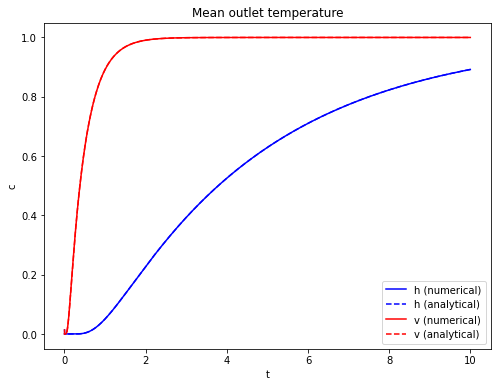

In [22]:
plt.figure(figsize=(8, 6))
cmap = {'h':'blue', 'v':'red'}
for i, (t, Tb) in btemps_val.items():
    label = i
    D_analytical = 0.1 if i == 'h' else 1.0
    Tb_analytical = analytical_solution(D_analytical, t)
    plt.plot(t, Tb, color=cmap[i], label=f'{label} (numerical)')
    plt.plot(t, Tb_analytical, color=cmap[i], label=f'{label} (analytical)', linestyle='--')
# plt.plot(t, analytical_solution(D_all.mean(), t), color='black', label="Geometric mean", alpha=0.5)
plt.xlabel("t")
plt.ylabel("c")
plt.title("Mean outlet temperature")
plt.legend()
plt.savefig("figures_heat/validation_curves.png")


In [23]:
btemps = dict()
for i in range(30):
    with np.load(f'results_heat/res_m0_random_{i}.npz') as data:
        T = data['T'][:-1]
        t = data['t']
        Tboundary = get_boundary_temperatures(T)
    #     theta0 = data['theta0']
        btemps[i] = [t, Tboundary]


In [24]:
for i, (t, Tb) in btemps.items():
    Db, Di = get_diffusion_values(t, Tb)
    btemps[i] += [Db, Di]

In [25]:
Db_all = np.array([v[2] for v in btemps.values()])
Di_all = np.array([v[3] for v in btemps.values()])
D_all = np.concatenate([Db_all, Di_all])
D_labels = [r'$D_b$']*len(Db_all) + [r'$D_i$']*len(Di_all)

In [26]:
geometric_mean = np.sqrt(1*1/10)

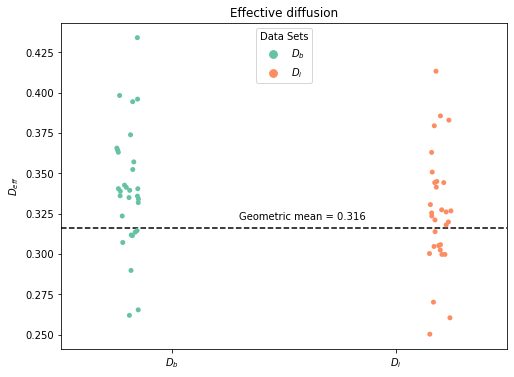

In [27]:
plt.figure(figsize=(8, 6))
seaborn.stripplot(y=D_all, x=D_labels, orient='v', jitter=True, dodge=True, hue=D_labels, palette="Set2")
plt.title('Effective diffusion')
plt.legend(title='Data Sets', loc='upper center')
plt.ylabel(r"$D_{eff}$")
plt.axhline(geometric_mean, color='black', linestyle='--')
plt.text(0.3, geometric_mean + 0.005, f'Geometric mean = {geometric_mean:.3f}')
plt.savefig("figures_heat/effective_diffusion.png")
plt.show()

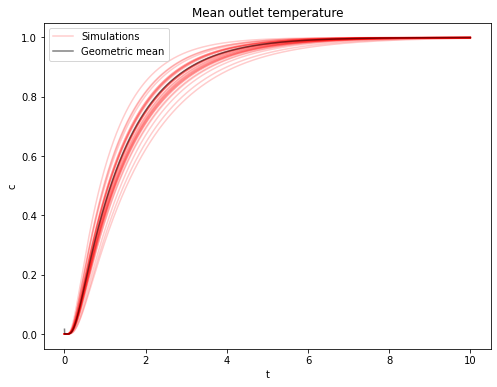

In [28]:
plt.figure(figsize=(8, 6))
for i, (t, Tb, _, _) in btemps.items():
    label = None if i > 0 else "Simulations"
    plt.plot(t, Tb, color='red', alpha=0.2, label=label)
plt.plot(t, analytical_solution(D_all.mean(), t), color='black', label="Geometric mean", alpha=0.5)
plt.xlabel("t")
plt.ylabel("c")
plt.title("Mean outlet temperature")
plt.legend()
plt.savefig("figures_heat/charging_curves.png")


In [29]:
pmesh = microstructpy.meshing.PolyMesh.from_file("microstructure.txt") 

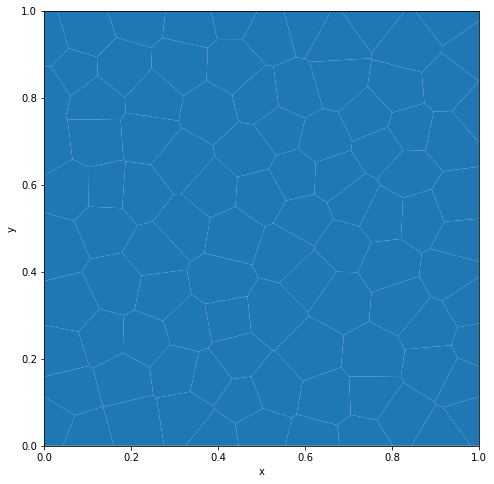

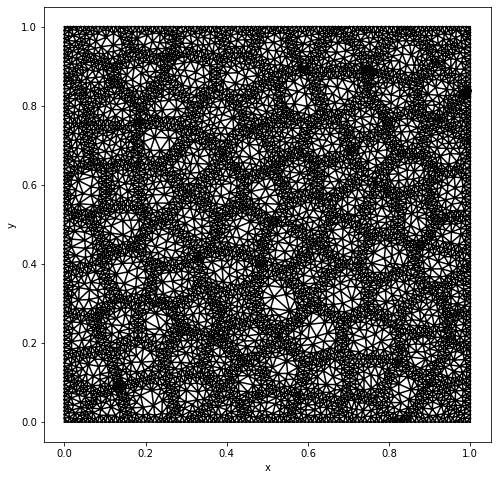

In [30]:
plt.figure(figsize=(8, 8))
pmesh.plot()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("figures_heat/pmeshfig.png")
plt.figure(figsize=(8, 8))
plt.triplot(mesh.points[:, 0], mesh.points[:, 1], mesh.cells_dict["triangle"], color='black')
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("figures_heat/meshfig.png")

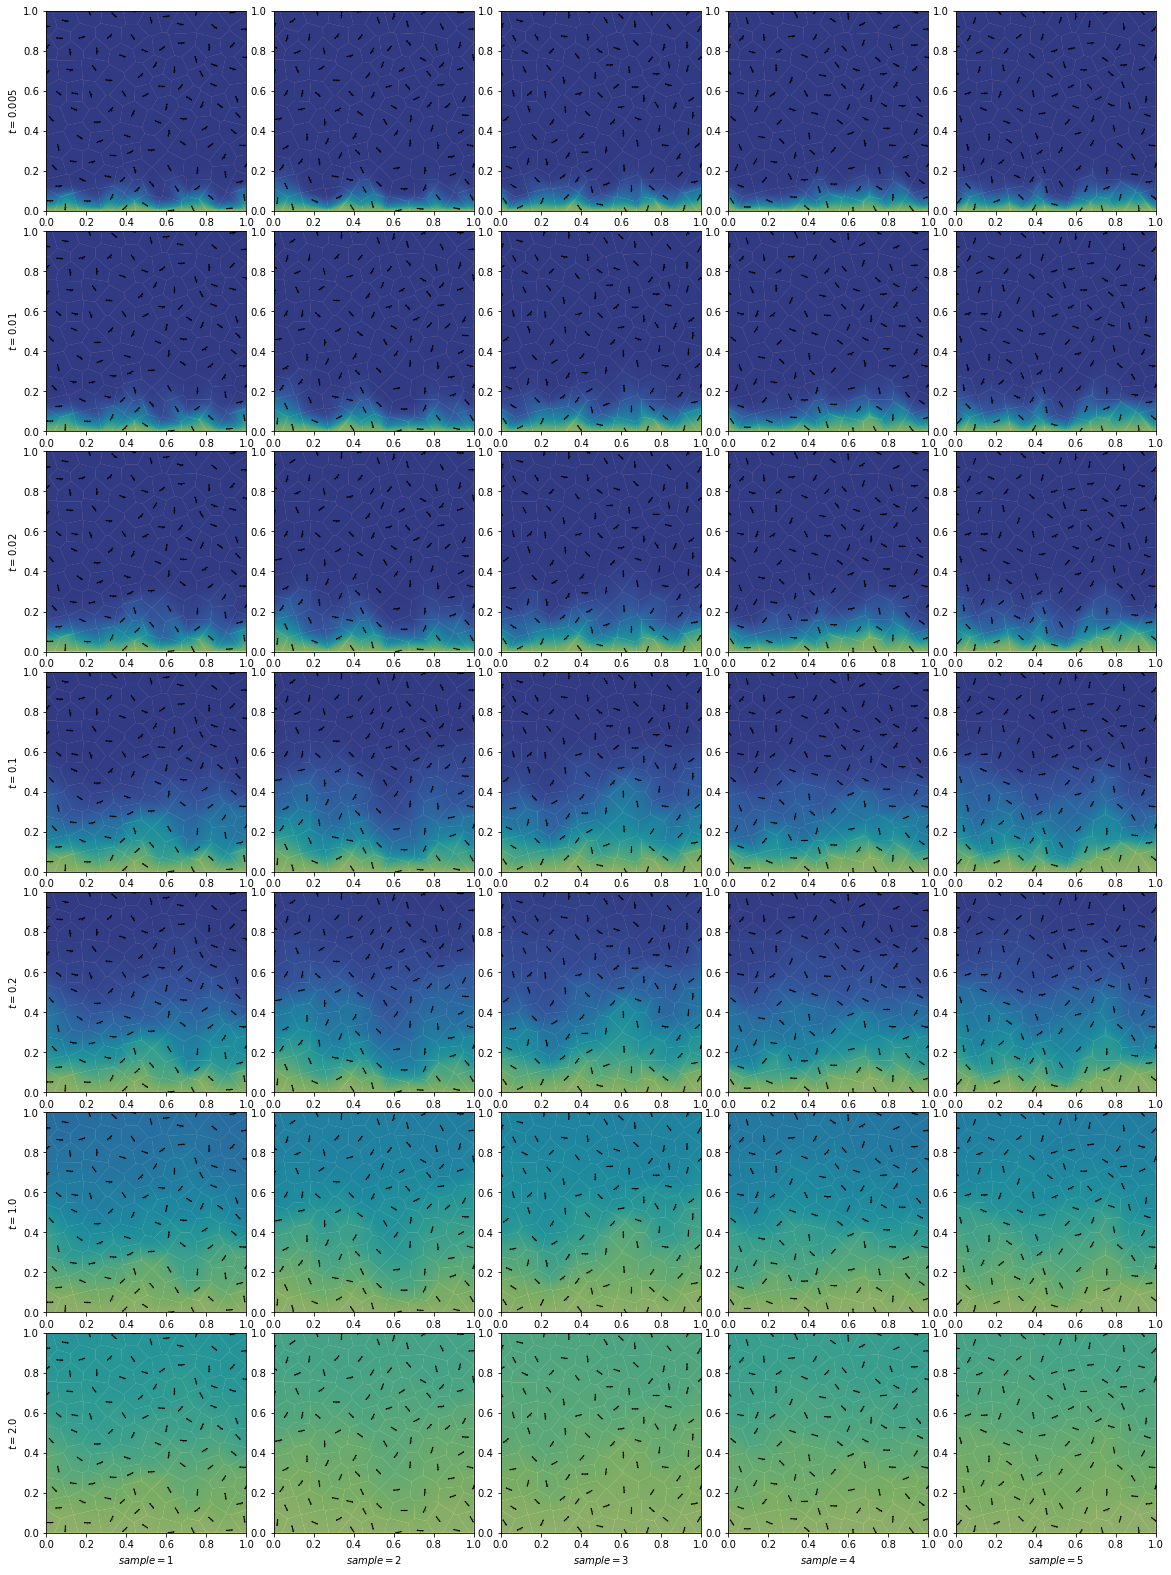

In [31]:
# Create a figure and grid spec
fig = plt.figure(figsize=(20, 28)) # Adjust the overall size as needed
gs = matplotlib.gridspec.GridSpec(7, 5, wspace=0.1, hspace=0.1)

# Iterate through deviations and frames
testnumbers = list(range(1, 6))
frames = [5, 10, 20, 100, 200, 1000, 2000]
for col, testnumber in enumerate(testnumbers):
    load_name = f'results_heat/res_m0_random_{testnumber}.npz'
    with np.load(load_name) as data:
        T = data['T']
        theta0 = data['theta0']
        t = data['t']
    for row, frame in enumerate(frames):
        ax = plt.subplot(gs[row, col])

        pmesh.plot()

        plt.scatter(centers[:, 0], centers[:, 1], color='black', s=1)
        arrow_length = 0.03

        for center, angle in zip(centers, theta0):
            dx = arrow_length * np.cos(angle)
            dy = arrow_length * np.sin(angle)
            arrow = matplotlib.patches.FancyArrowPatch((center[0]-dx, center[1]-dy),
                                                       (center[0] + dx, center[1] + dy),
                                                       arrowstyle='<|-|>', lw=1, color='black')
            ax.add_patch(arrow)

        X, Y = np.meshgrid(np.linspace(0, 1, 201), np.linspace(0, 1, 201))
        Txy = scipy.interpolate.LinearNDInterpolator(mesh.points[:, :-1], T[frame])(X, Y)
        plt.pcolormesh(X, Y, Txy, shading='auto', vmin=0.0, vmax=1.0, alpha=0.5)


        if row == 6:
            plt.xlabel(f"$sample={testnumber}$")
        if col == 0:
            plt.ylabel(f"$t={t[frame]}$")

plt.savefig("figures_heat/evolution_plot.png", bbox_inches='tight', pad_inches=0)

NameError: name 'assembler' is not defined

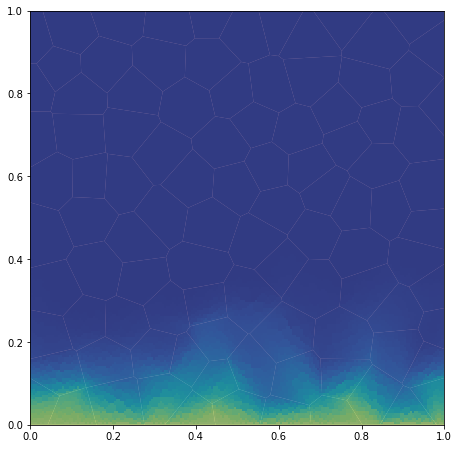

In [32]:
# Create a figure and grid spec
fig = plt.figure(figsize=(16, 16))
gs = matplotlib.gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.1)

# Define the color and length of arrows
arrow_color = 'black'
arrow_length = 0.02
head_length = 1  # Length of the arrowhead
head_width = 2.0  # Width of the arrowhead
head_axis_length = 1.5  # Length of the arrowhead along the arrow axis

# Iterate through frames
frames = [20, 100, 200, 1000]
testnumber = 1
load_name = f'results_heat/res_m0_random_{testnumber}.npz'
with np.load(load_name) as data:
    T = data['T']
    theta0 = data['theta0']
    t = data['t']
for idx, frame in enumerate(frames):
    ax = plt.subplot(gs[idx // 2, idx % 2])

    theta_markers = np.array([theta0[marker] for marker in grain_markers])
    rotations = np.stack([
        np.stack([np.cos(theta_markers), np.sin(theta_markers)], axis=-1),
        np.stack([-np.sin(theta_markers), np.cos(theta_markers)], axis=-1)],
        axis=-1)
    principal_directions = np.diag([1, 0.1])
    diffusions = rotations @ (principal_directions) @ (rotations.swapaxes(2, 1))

    pmesh = microstructpy.meshing.PolyMesh.from_file("microstructure.txt")
    pmesh.plot()

    X, Y = np.meshgrid(np.linspace(0, 1, 201), np.linspace(0, 1, 201))
    Txy = scipy.interpolate.NearestNDInterpolator(mesh.points[:, :-1], T[frame])(X, Y)
    plt.pcolormesh(X, Y, Txy, shading='auto', vmin=0.0, vmax=1.0, alpha=0.5)

    gradxy = assembler.get_linear_element_equation(T[frame])[:, :-1]
    centroids = assembler.centroids[..., :-1]
    fluxxy = -np.einsum('...ij, ...j -> ...i', diffusions, gradxy)
    X, Y = np.meshgrid(np.linspace(0, 1, 51), np.linspace(0, 1, 51))
    XGrad = scipy.interpolate.NearestNDInterpolator(centroids, fluxxy[:, 0])(X, Y)
    YGrad = scipy.interpolate.NearestNDInterpolator(centroids, fluxxy[:, 1])(X, Y)

    magnitudes = np.sqrt(XGrad ** 2 + YGrad ** 2)
    max_magnitudes = 3.0
    eps_magnitudes = 1e-3
    XGrad_norm = XGrad / (magnitudes + eps_magnitudes)
    YGrad_norm = YGrad / (magnitudes + eps_magnitudes)

    # Calculate alpha values
    alphas = np.clip(magnitudes / max_magnitudes, 0.0, 0.8)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if alphas[i, j] < eps_magnitudes:
                continue
            else:
                ax.quiver(X[i, j], Y[i, j], XGrad_norm[i, j], YGrad_norm[i, j],
                          color=arrow_color, alpha=alphas[i, j], scale=1 / arrow_length,
                          width=0.2 * arrow_length,
                          headlength=head_length, headwidth=head_width, headaxislength=head_axis_length)
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    ax.set_title(f"$t = {t[frame]}$")

fig.savefig("figures_heat/fluxes.png", bbox_inches='tight', pad_inches=0)